# Trajectory Tracking Analysis - Publication Quality

This notebook demonstrates how to analyze trajectory tracking data from CSV files,
automatically detect trajectory planes, calculate RMSE metrics, and generate
publication-quality figures for your research paper.

## Features
- Automatic CSV loading with column name cleaning
- Automatic trajectory plane detection (XY, XZ, or YZ)
- RMSE calculation per trajectory and controller
- Publication-quality plots with LaTeX formatting
- PDF export for Overleaf/LaTeX documents
- Data tables with RMSE and computation time metrics

## 1. Import Libraries

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utilities import *

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Configuration

In [18]:
# Path to log files directory
logs_path = "log_files/"

# Output directory for figures and tables
output_path = "output/"
os.makedirs(output_path, exist_ok=True)

## 3. Load All CSV Files

This will automatically load all CSV files from the log_files directory and clean the column names.

In [19]:
# Load all CSV files
data_dict = load_all_csvs(logs_path)

print(f"Loaded {len(data_dict)} CSV files:")
for filename in data_dict.keys():
    print(f"  - {filename}")

Loaded 2 CSV files:
  - sampling1.csv
  - no_sampling1.csv


In [20]:
df = data_dict[list(data_dict.keys())[0]]  # Use the first file for demonstration

In [21]:
time = df['traj_time'].values
time

array([ 0.22042298,  0.32372522,  0.42507696,  0.51901412,  0.62294054,
        0.73150206,  0.82717276,  0.92099309,  1.02800989,  1.12778306,
        1.22263837,  1.31906772,  1.42018509,  1.52503109,  1.62553811,
        1.73016787,  1.82389212,  1.92179871,  2.01988816,  2.12521076,
        2.23829961,  2.3358283 ,  2.42352104,  2.5319798 ,  2.63296628,
        2.72650981,  2.82004285,  2.9257009 ,  3.02162051,  3.12397265,
        3.22671199,  3.31982565,  3.43842196,  3.52693057,  3.63612866,
        3.7268796 ,  3.82098603,  3.9306705 ,  4.02053642,  4.12390137,
        4.22360325,  4.32782984,  4.4221611 ,  4.53018713,  4.62057781,
        4.72890615,  4.82022285,  4.9218998 ,  5.02556658,  5.13026571,
        5.21943188,  5.32033586,  5.43140554,  5.52282047,  5.62061596,
        5.71981525,  5.82798386,  5.92694759,  6.02729225,  6.12151671,
        6.22030735,  6.32459354,  6.42184305,  6.5194025 ,  6.62634277,
        6.73072433,  6.82065773,  6.92642355,  7.02830362,  7.13

## 4. Inspect Dataset Metadata

The system automatically extracts platform, controller, and trajectory information from the logged data columns (not from filenames).

In [22]:
# Print metadata for all datasets
print_dataset_metadata(data_dict)

# Get the first dataset for detailed inspection
print("\n" + "=" * 80)
print("DETAILED INSPECTION OF FIRST DATASET")
print("=" * 80)

first_file = list(data_dict.keys())[0]
df_sample = data_dict[first_file]

print(f"\nDataset: {first_file}")
print(f"Shape: {df_sample.shape}")
print(f"\nColumn names:")
print(df_sample.columns.tolist())
print(f"\nFirst few rows:")
df_sample.head()

Dataset Metadata (from logged data):

sampling1.csv:
  Platform:    Simulation
  Controller:  NR Standard
  Trajectory:  Circle H
  Modifiers:   2x speed, spinning

no_sampling1.csv:
  Platform:    Simulation
  Controller:  NR Standard
  Trajectory:  Circle H
  Modifiers:   2x speed, spinning

DETAILED INSPECTION OF FIRST DATASET

Dataset: sampling1.csv
Shape: (298, 38)

Column names:
['time', 'ax', 'ay', 'az', 'comp_time', 'controller', 'lookahead_time', 'p', 'pitch', 'platform', 'q', 'r', 'roll', 'timestamp', 'timestamp_sample', 'traj_double', 'traj_spin', 'traj_time', 'trajectory', 'u_p', 'u_q', 'u_r', 'u_throttle', 'vx', 'vx_ref', 'vy', 'vy_ref', 'vz', 'vz_ref', 'x', 'x_ref', 'y', 'y_ref', 'yaw', 'yaw_ref', 'yawd_ref', 'z', 'z_ref']

First few rows:


,time,ax,ay,az,comp_time,controller,lookahead_time,p,pitch,platform,...,vz_ref,x,x_ref,y,y_ref,yaw,yaw_ref,yawd_ref,z,z_ref
0,1.759716e+09,0.051981,0.010842,-0.152795,0.000896,0.0,1.2,-0.008641,-0.007296,0.0,...,0.0,0.952287,0.117880,0.892476,0.588306,-0.006692,0.446239,0.314159,-3.795795,-5.0
1,1.759716e+09,-0.070415,-0.020052,-0.378386,0.000916,0.0,1.2,-0.044651,0.004781,0.0,...,0.0,0.949836,0.058644,0.895433,0.597127,-0.004251,0.478692,0.314159,-3.814192,-5.0
2,1.759716e+09,-0.308920,-0.064684,-0.616250,0.002136,0.0,1.2,-0.029964,0.028390,0.0,...,0.0,0.944130,-0.000045,0.898173,0.600000,0.005453,0.510533,0.314159,-3.830520,-5.0
3,1.759716e+09,-0.576623,-0.092267,-0.488284,0.000813,0.0,1.2,-0.025002,0.055023,0.0,...,0.0,0.939050,-0.054452,0.894062,0.597524,0.022642,0.540044,0.314159,-3.850372,-5.0
4,1.759716e+09,-0.756503,-0.126739,-0.363373,0.000954,0.0,1.2,-0.028846,0.073894,0.0,...,0.0,0.931553,-0.114104,0.894165,0.589050,0.044117,0.572694,0.314159,-3.869776,-5.0


In [23]:
df_sample.traj_time[0:-1]

0       0.220423
1       0.323725
2       0.425077
3       0.519014
4       0.622941
         ...    
292    29.418839
293    29.518730
294    29.619034
295    29.718908
296    29.818748
Name: traj_time, Length: 297, dtype: float64

## 5. Automatic Trajectory Plane Detection

The system automatically detects which plane the trajectory is moving in (XY, XZ, or YZ) based on variance in the reference trajectory.

In [24]:
# Detect trajectory plane for each dataset
for filename, df in data_dict.items():
    plane = detect_trajectory_plane(df)
    print(f"{filename}: detected plane = {plane.upper()}")

sampling1.csv: detected plane = XY
no_sampling1.csv: detected plane = XY


## 6. RMSE Analysis

Calculate RMSE metrics for all datasets.

In [25]:
# Calculate RMSE for each file
print("RMSE Analysis:")
print("=" * 60)

for filename, df in data_dict.items():
    rmse_overall = calculate_overall_rmse(df)
    rmse_position = calculate_position_rmse(df)
    rmse_per_axis = calculate_rmse_per_axis(df)
    comp_time = calculate_mean_comp_time(df)
    
    print(f"\n{filename}:")
    print(f"  Overall RMSE (x,y,z,yaw): {rmse_overall:.4f} m")
    print(f"  Position RMSE (x,y,z):    {rmse_position:.4f} m")
    print(f"  Per-axis RMSE:")
    print(f"    X: {rmse_per_axis['x']:.4f} m")
    print(f"    Y: {rmse_per_axis['y']:.4f} m")
    print(f"    Z: {rmse_per_axis['z']:.4f} m")
    print(f"    Yaw: {rmse_per_axis['yaw']:.4f} rad")
    if comp_time is not None:
        print(f"  Mean computation time: {comp_time:.2f} ms")

RMSE Analysis:
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)

sampling1.csv:
  Overall RMSE (x,y,z,yaw): nan m
  Position RMSE (x,y,z):    nan m
  Per-axis RMSE:
    X: nan m
    Y: nan m
    Z: nan m
    Yaw: nan rad
  Mean computation time: 0.92 ms
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)

no_sampling1.csv:
  Overall RMSE (x,y,z,yaw): nan m
  Position RMSE (x,y,z):    nan m
  Per-axis RMSE:
    X: nan m
    Y: nan m
    Z: nan m
    Yaw: nan rad
  Mean computation time: 0.33 ms


## 7. Generate Results Table

The table now automatically extracts platform, controller, and trajectory information from the logged data.

In [26]:
# Generate results table using metadata from logged data
# use_data_metadata=True extracts platform, controller, trajectory from the data columns
# This is more accurate than filename parsing
results_df = generate_results_table(data_dict, use_data_metadata=True)

print("Results Table:")
print("=" * 100)
print(results_df.to_string(index=False))

# Save as CSV
results_df.to_csv(f"{output_path}results_table.csv", index=False)
print(f"\n✓ Saved to {output_path}results_table.csv")

# Optional: If you want to use filename-based extraction (deprecated), use:
# results_df = generate_results_table(data_dict, use_data_metadata=False, 
#                                     controller_map={'nr': 'Newton-Raphson', ...},
#                                     trajectory_map={'circle': 'Circle', ...})

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Results Table:
  Platform  Controller Trajectory Modifiers  Position_RMSE_m  Comp_Time_ms
Simulation NR Standard   Circle H   2x+spin              NaN      0.917941
Simulation NR Standard   Circle H   2x+spin              NaN      0.326628

✓ Saved to output/results_table.csv


## 8. Export LaTeX Table

Generate a LaTeX-formatted table ready for your paper.

In [27]:
# Generate LaTeX table
latex_table = format_latex_table(results_df)

# Save to file
with open(f"{output_path}results_table.tex", 'w') as f:
    f.write(latex_table)

print("LaTeX Table:")
print(latex_table)
print(f"\nSaved to {output_path}results_table.tex")

LaTeX Table:
\begin{tabular}{llllrr}
\toprule
Platform & Controller & Trajectory & Modifiers & Position_RMSE_m & Comp_Time_ms \\
\midrule
Simulation & NR Standard & Circle H & 2x+spin & NaN & 0.9179 \\
Simulation & NR Standard & Circle H & 2x+spin & NaN & 0.3266 \\
\bottomrule
\end{tabular}


Saved to output/results_table.tex


## 9. Plot Single Trajectory (2D)

Create a publication-quality 2D trajectory plot with automatic plane detection.

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)


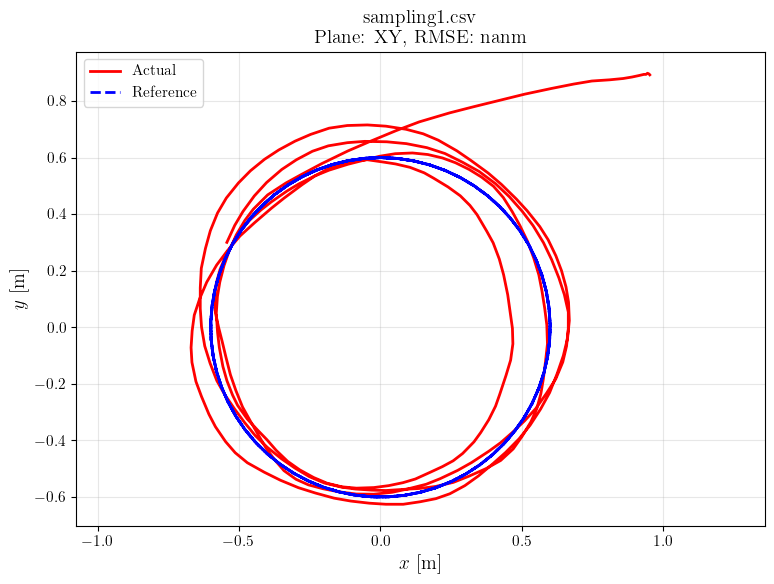

Saved to output/single_trajectory.pdf


In [28]:
# Setup publication style
setup_publication_style()

# Plot the first dataset
first_file = list(data_dict.keys())[0]
df_plot = data_dict[first_file]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_trajectory_2d(ax, df_plot)

plane = detect_trajectory_plane(df_plot)
rmse = calculate_position_rmse(df_plot)
ax.set_title(f"{first_file}\nPlane: {plane.upper()}, RMSE: {rmse:.3f}m", fontweight='bold')

plt.tight_layout()
plt.savefig(f"{output_path}single_trajectory.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(f"Saved to {output_path}single_trajectory.pdf")

In [29]:
import matplotlib as mpl, shutil
print("usetex:", mpl.rcParams.get("text.usetex"))
print("latex in PATH:", shutil.which("latex"))
print("dvipng:", shutil.which("dvipng"))
print("dvisvgm:", shutil.which("dvisvgm"))
print("gs (ghostscript):", shutil.which("gs"))


usetex: True
latex in PATH: /usr/bin/latex
dvipng: /usr/bin/dvipng
dvisvgm: /usr/bin/dvisvgm
gs (ghostscript): /usr/bin/gs


## 10. Plot Time Series

Create time series plots showing position and yaw over time.

Aligning data: shifting reference values back by 1.20s (12 samples)
Figure saved to output/time_series.pdf


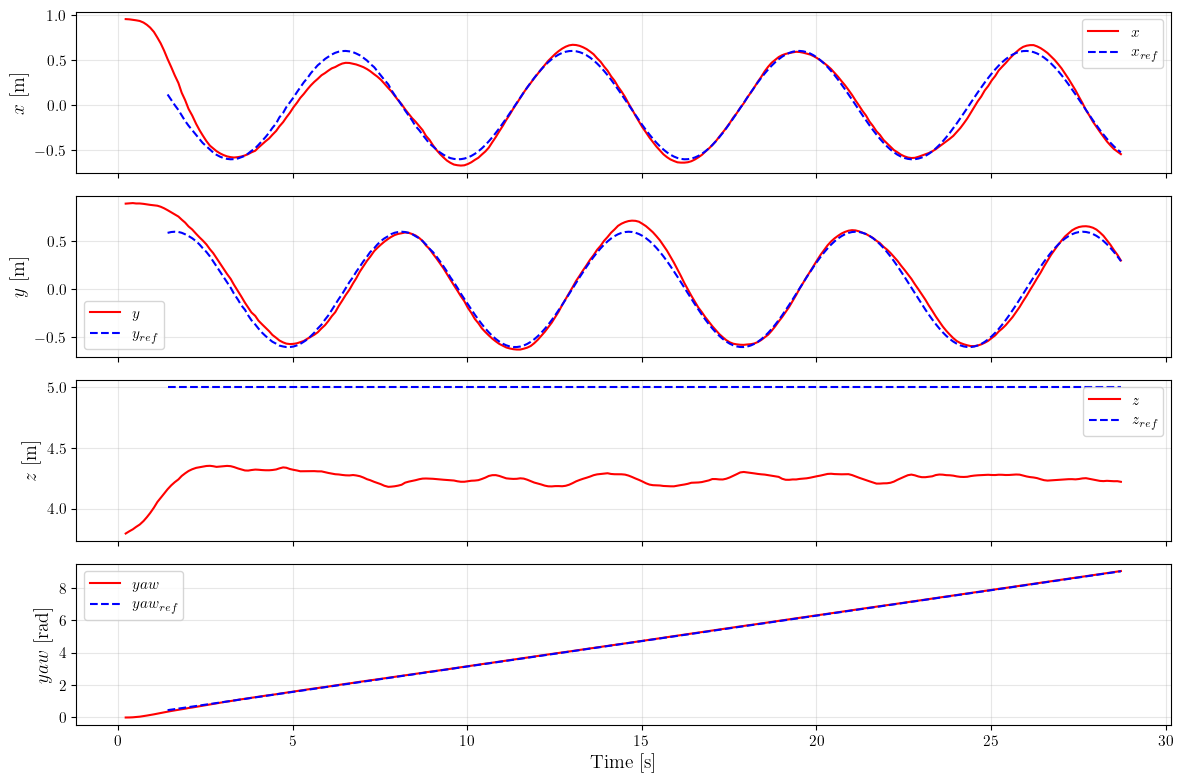

Saved to output/time_series.pdf


In [30]:
# Plot time series for first dataset
first_file = list(data_dict.keys())[0]
df_plot = data_dict[first_file]

fig = plot_time_series(df_plot, 
                       vars_to_plot=['x', 'y', 'z', 'yaw'],
                       save_path=f"{output_path}time_series.pdf")

plt.show()
print(f"Saved to {output_path}time_series.pdf")

## 11. Multi-Controller Comparison Plot

Create a comprehensive comparison plot with multiple controllers and trajectories.

**Note:** Customize the `controller_groups` dictionary based on your file naming convention.
The example below assumes files are named like `controller_trajectory.csv`.

Controller groups:
  With Sampling: ['sampling1.csv', 'no_sampling1.csv']
  No Sampling: ['no_sampling1.csv']
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Figure saved to output/multi_controller_comparison.pdf


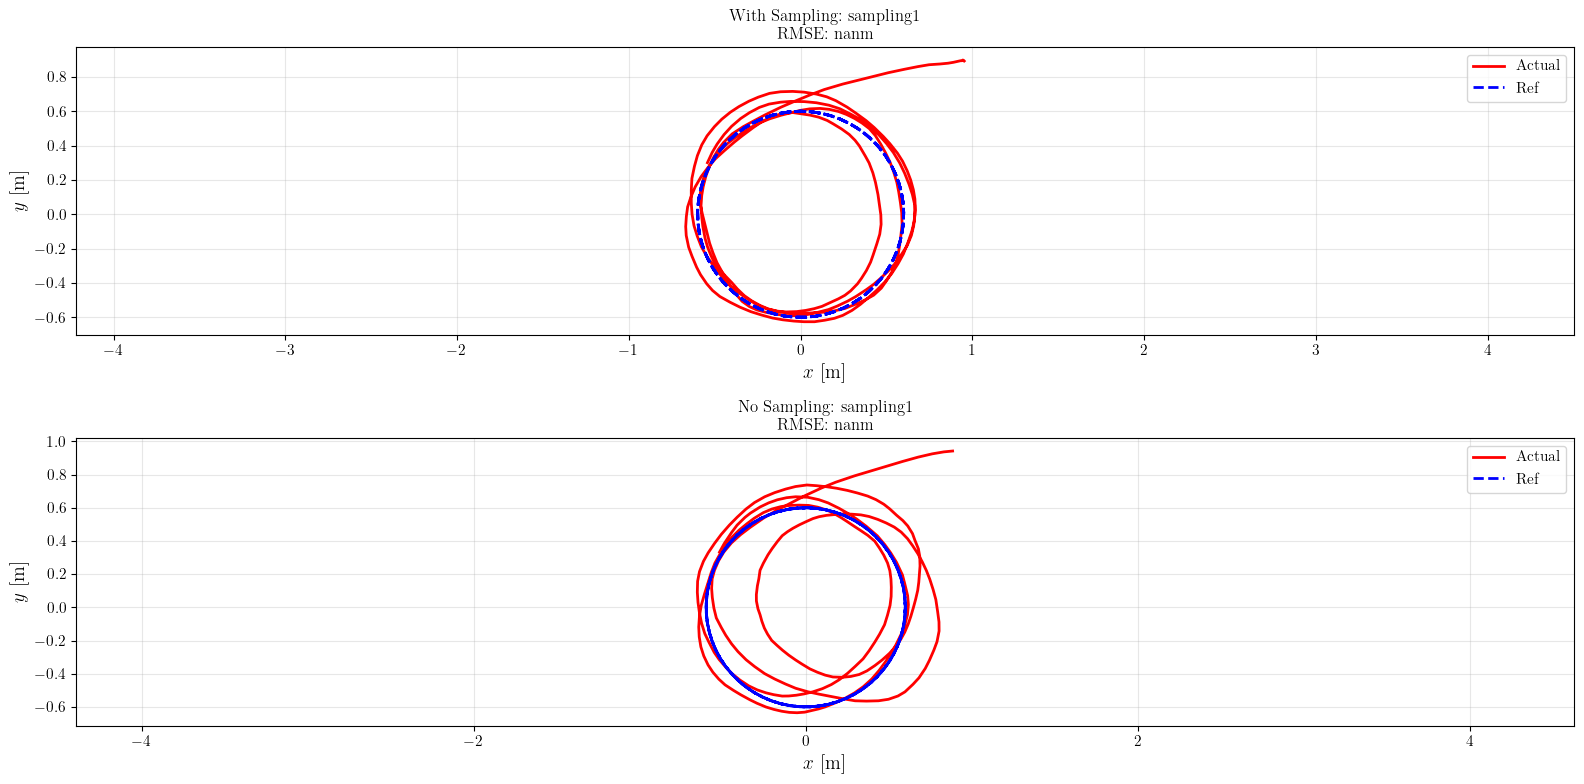

Saved to output/multi_controller_comparison.pdf


In [31]:
# Define controller groups based on your file naming
# Customize this based on your actual file names!
controller_groups = {
    'With Sampling': [f for f in data_dict.keys() if 'sampling1' in f],
    'No Sampling': [f for f in data_dict.keys() if 'no_sampling1' in f],
}

# Remove empty groups
controller_groups = {k: v for k, v in controller_groups.items() if len(v) > 0}

if len(controller_groups) > 0:
    print("Controller groups:")
    for controller, files in controller_groups.items():
        print(f"  {controller}: {files}")
    
    # Create multi-controller comparison plot
    fig = plot_multi_controller_comparison(
        data_dict,
        controller_groups,
        figsize=(16, 8),
        save_path=f"{output_path}multi_controller_comparison.pdf"
    )
    
    plt.show()
    print(f"Saved to {output_path}multi_controller_comparison.pdf")
else:
    print("No controller groups found. Please customize the controller_groups dictionary above.")

## 12. Custom Analysis Example

Here's an example of how to create custom plots for specific use cases.

Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)
Aligning data: shifting reference values back by 1.20s (12 samples)


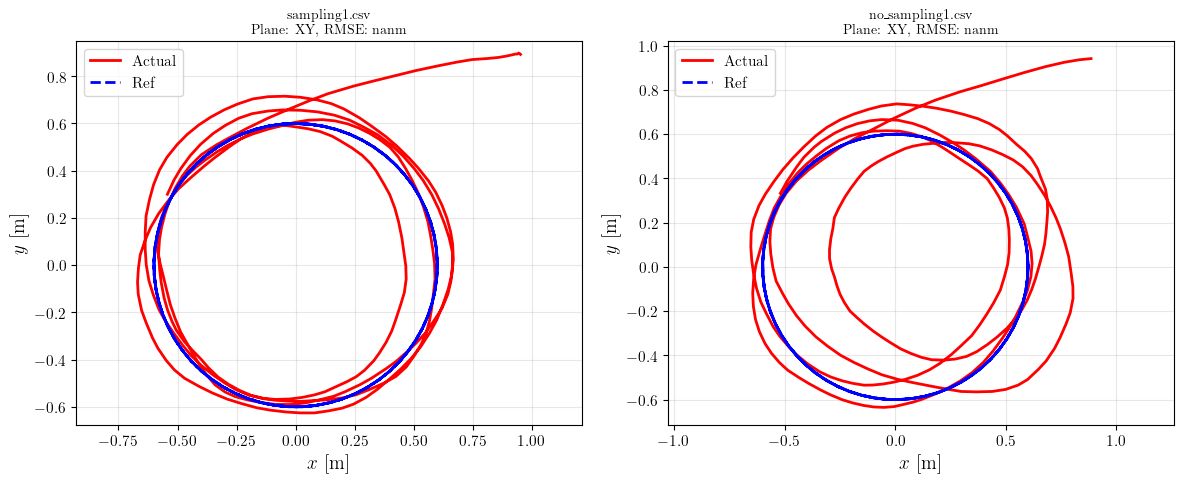

Saved to output/all_trajectories_grid.pdf


In [32]:
# Example: Create a grid of all trajectories
setup_publication_style()

n_files = len(data_dict)
n_cols = min(3, n_files)  # Max 3 columns
n_rows = (n_files + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
if n_files == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, (filename, df) in enumerate(data_dict.items()):
    ax = axes[idx]
    plot_trajectory_2d(ax, df, actual_label='Actual', ref_label='Ref')
    
    plane = detect_trajectory_plane(df)
    rmse = calculate_position_rmse(df)
    ax.set_title(f"{filename}\nPlane: {plane.upper()}, RMSE: {rmse:.3f}m", 
                fontsize=10, fontweight='bold')

# Hide unused subplots
for idx in range(n_files, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(f"{output_path}all_trajectories_grid.pdf", format='pdf', bbox_inches='tight')
plt.show()

print(f"Saved to {output_path}all_trajectories_grid.pdf")

## 13. Summary

### Key Features:
- **Automatic Metadata Extraction**: Platform, controller, and trajectory information is extracted directly from the logged data columns (not from filenames)
- **Trajectory Modifiers**: Automatically detects and includes 2x speed and spinning modifiers
- **Automatic Plane Detection**: Detects whether trajectories are in XY, XZ, or YZ planes
- **Publication-Quality Outputs**: LaTeX-formatted tables and high-resolution PDF figures

### Output Files Generated:
- `output/results_table.csv` - Results in CSV format with Platform, Controller, Trajectory, Modifiers, RMSE, and Computation Time
- `output/results_table.tex` - LaTeX table ready for your paper
- `output/single_trajectory.pdf` - Example single trajectory plot
- `output/time_series.pdf` - Time series plot
- `output/multi_controller_comparison.pdf` - Multi-controller comparison
- `output/all_trajectories_grid.pdf` - Grid of all trajectories

### How It Works:
The analysis now uses the enumeration values logged in your data:
- `platform` column (0=Sim, 1=Hardware)
- `controller` column (0=NR Standard, 1=NR Enhanced, 2=MPC)
- `trajectory` column (0=Hover, 1=Circle H, 2=Circle V, 3=Fig8 H, etc.)
- `traj_double` and `traj_spin` boolean columns for trajectory modifiers

This approach is **more accurate** than filename parsing and ensures your analysis always reflects the actual test configuration.

### Next Steps:
1. Run your experiments and save the data to `log_files/` directory
2. Run this notebook to generate analysis
3. Include the generated PDF figures in your Overleaf document
4. Copy the LaTeX table code into your paper

### Tips:
- All metadata is automatically extracted from your logged data - no manual filename parsing needed!
- The system detects trajectory planes (XY, XZ, YZ) automatically based on variance
- All plots use publication-quality LaTeX formatting
- RMSE is calculated separately for position (x,y,z) and overall (x,y,z,yaw)